# TSMixer: Tuning

### Setup

In [1]:
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
from itertools import product
from tqdm import tqdm
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/replication-sari-forecasting/.venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [3]:
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

### Configuration

In [4]:
NAME = 'tsmixer'
OUT_CSV = "gridsearch_tsmixer.csv"
RANDOM_SEEDS = [1, 2, 3]

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : False,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "logger" : False,
       #"callbacks" : [RichProgressBar(leave=True)],
       #"dataloader_kwargs" :  {"pin_memory": torch.cuda.is_available()}
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

In [6]:
sweep_configuration = {
    "name": f"sari-{NAME}",
    "method": "grid",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "model" : {"values" : [NAME]},
        "use_static_covariates" :  {"values" : [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True]},
        "sample_weight" : {"values" : ["linear", "no-covid"]},
        "input_chunk_length" : {"values" : [8]},
        "hidden_size" : {"values" : [32, 64]},
        "ff_size" : {"values" : [32, 64]},
        "num_blocks" : {"values" : [4, 6]},
        "dropout" : {"values" : [0.2]}, # 0.05, 0.1, 0.2, 0.3, 0.5
        "norm_type"  : {"values" : ['TimeBatchNorm2d']}, # 'LayerNorm', 
        "batch_size" : {"values" : [32]},
        "n_epochs" : {"values" : [500, 1000]},
        "normalize_before" : {"values" : [False]},
        "activation" : {"values" : ["ReLU"]}, # "ReLU", "GELU", "LeakyReLU", "ELU"
        "optimizer" : {"values": ["AdamW"]}, # SGD, "Adam", 
        "optimizer_kwargs" : {
            "parameters": {
                "lr" : {"values" : [0.0005, 0.001, 0.005]},
                "weight_decay" : {"values" : [0, 0.001, 0.0001]}
            }
        }
    }
}

In [7]:
def space_from_sweep(sweep_cfg: dict) -> dict:
    space = {}
    for k, v in sweep_cfg["parameters"].items():
        if k == "optimizer_kwargs":  # special case: flatten
            sub = v["parameters"]
            space["optimizer_kwargs.lr"] = list(sub["lr"]["values"])
            space["optimizer_kwargs.weight_decay"] = list(sub["weight_decay"]["values"])
        else:
            space[k] = list(v["values"])
    return space

In [8]:
def iter_configs(space: dict):
    keys = list(space.keys())
    for vals in product(*(space[k] for k in keys)):
        yield dict(zip(keys, vals))

### Load data

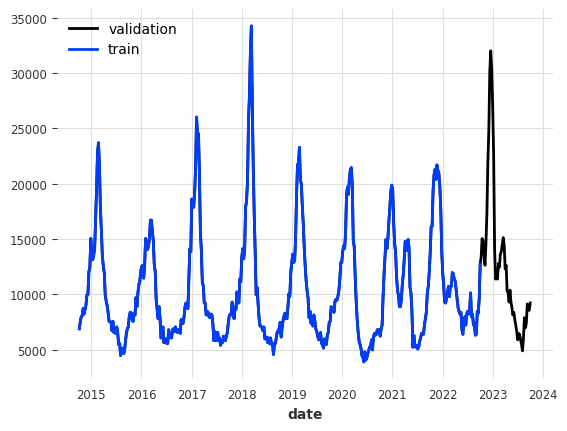

In [9]:
targets, covariates = load_realtime_training_data()

targets_train, targets_validation = train_validation_split(targets, 2022)

targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

custom_weights = exclude_covid_weights(targets)

In [12]:
def eval_config(cfg: dict) -> dict:
    optimizer = OPTIMIZER_DICT[cfg["optimizer"]]
    use_covariates = cfg["use_covariates"]
    sample_weight = cfg["sample_weight"]

    model = TSMixerModel(
        input_chunk_length=cfg["input_chunk_length"],
        hidden_size=cfg["hidden_size"],
        ff_size=cfg["ff_size"],
        num_blocks=cfg["num_blocks"],
        dropout=cfg["dropout"],
        norm_type=cfg["norm_type"],
        batch_size=cfg["batch_size"],
        n_epochs=cfg["n_epochs"],
        normalize_before=cfg["normalize_before"],
        activation=cfg["activation"],
        optimizer_cls=optimizer,
        optimizer_kwargs={
            "lr": cfg["optimizer_kwargs.lr"],
            "weight_decay": cfg["optimizer_kwargs.weight_decay"],
        },
        use_static_covariates=cfg["use_static_covariates"],
        add_encoders=ENCODERS if cfg["use_encoders"] else None,
        **SHARED_ARGS,
    )

    scores = {}
    for seed in RANDOM_SEEDS:
        model.reset_model()
        model.model_params["random_state"] = seed
        score = compute_validation_score(
            model,
            targets_train,
            targets_validation,
            covariates if use_covariates else None,
            HORIZON,
            NUM_SAMPLES,
            METRIC,
            METRIC_KWARGS,
            sample_weight=custom_weights if sample_weight == "no-covid" else sample_weight,
        )
        scores[f"WIS_{seed}"] = score
        print(score)

    per_seed = list(scores.values())
    scores["WIS"] = np.mean(per_seed)
    scores["WIS_std"] = np.std(per_seed)
    
    return {
        **scores,
        **{f"cfg.{k}": v for k, v in cfg.items()},
    }

In [13]:
def run_gridsearch(resume=False):
    space   = space_from_sweep(sweep_configuration)
    configs = list(iter_configs(space))

    param_cols = list(space.keys())
    score_cols = ["WIS_1", "WIS_2", "WIS_3", "WIS", "WIS_std"]
    header     = param_cols + score_cols + ["error_flag", "error_msg"]

    if resume and os.path.exists(OUT_CSV):
        gs = pd.read_csv(OUT_CSV)

        # convert string representations into dicts and tuples
        gs["lags_past_covariates"] = gs["lags_past_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        gs["lags_future_covariates"] = gs["lags_future_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

        gs = gs.drop(columns=['WIS', 'error_flag', 'error_msg']).to_dict('records')
        configs = [c for c in configs if c not in gs]
    
    if not os.path.exists(OUT_CSV):
        pd.DataFrame(columns=header).to_csv(OUT_CSV, index=False)
        
    total = len(configs)
    pbar = tqdm(configs, total=total, desc="Grid search", unit="trial")
    for cfg in pbar:
        row = {k: cfg.get(k) for k in param_cols}
        try:
            res = eval_config(cfg)
            for sc in score_cols:
                row[sc] = res.get(sc, np.nan)
            row.update({"error_flag": False, "error_msg": ""})
            wis = row["WIS"]
        except Exception as e:
            for sc in score_cols:
                row[sc] = np.nan
            row.update({"error_flag": True, "error_msg": str(e)})
            wis = np.nan

        pd.DataFrame([row], columns=header).to_csv(
            OUT_CSV, mode="a", header=False, index=False
        )

        pbar.set_postfix({
            "WIS": f"{wis:.4f}" if isinstance(wis, (float, np.floating)) and not np.isnan(wis) else "nan",
        })

In [ ]:
run_gridsearch()

Grid search:   0%|          | 0/576 [00:00<?, ?trial/s]/home/wolffram/replication-sari-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


# Testing

In [10]:
space   = space_from_sweep(sweep_configuration)
configs = list(iter_configs(space))

In [11]:
cfg = configs[10]

In [25]:
optimizer = OPTIMIZER_DICT[cfg["optimizer"]]
use_covariates = cfg["use_covariates"]
sample_weight = cfg["sample_weight"]

In [26]:
model = TSMixerModel(
    input_chunk_length=cfg["input_chunk_length"],
    hidden_size=cfg["hidden_size"],
    ff_size=cfg["ff_size"],
    num_blocks=cfg["num_blocks"],
    dropout=cfg["dropout"],
    norm_type=cfg["norm_type"],
    batch_size=cfg["batch_size"],
    n_epochs=cfg["n_epochs"],
    normalize_before=cfg["normalize_before"],
    activation=cfg["activation"],
    optimizer_cls=optimizer,
    optimizer_kwargs={
        "lr": cfg["optimizer_kwargs.lr"],
        "weight_decay": cfg["optimizer_kwargs.weight_decay"],
    },
    use_static_covariates=cfg["use_static_covariates"],
    add_encoders=ENCODERS if cfg["use_encoders"] else None,
    **SHARED_ARGS,
)

In [ ]:
model.fit(targets_train, past_covariates=covariates, sample_weight=sample_weight,
         dataloader_kwargs = {"pin_memory": torch.cuda.is_available()}
)